In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import msBO
from msBO import plot_msGP_over_states
from msBO.utils import plot_2D_projection
from msBO import construct_machineIO as mIO
from pprint import pprint

In [2]:
import warnings
from contextlib import contextmanager

@contextmanager
def capture_warnings():
    warnings.simplefilter("always")
    yield
    with warnings.catch_warnings(record=True) as ws:
        for w in ws:
            print(w.message)
            print(f"{w.filename}, line {w.lineno}")

In [11]:
n_init = 2
n_eval = 2
beta = 4

In [3]:
timespan_for_average = 3    # sec  
additional_wait_after_powersupply_ramp  = 1 # sec

In [4]:
with capture_warnings():
    machineIO = mIO.construct_machineIO(isOK_PVs = None, #["ACS_DIAG:CHP:STATE_RD"],
                                        isOK_vals = None, #[3],
                                        set_manually=True)
# machineIO.isOK_PVs = None

In [5]:
machineIO.ensure_set_timewait_after_ramp = additional_wait_after_powersupply_ramp
machineIO.fetch_data_time_span = timespan_for_average

In [6]:
sample_interval = 0.2
control_CSETs = ['FS1_BBS:PSQ_D2416:I_CSET']
control_RDs   = ['FS1_BBS:PSQ_D2416:I_RD']
control_tols  = [0.5]

x0,df = machineIO._fetch_data(control_CSETs,0.1)
with capture_warnings():
    control_Lo_limit, control_Hi_limit = mIO.get_limits(control_CSETs,machineIO)
control_min  = [x0[0]*0.96]
control_max  = [x0[0]*1.04]
control_min = np.clip(control_min, a_min = control_Lo_limit, a_max = None)
control_max = np.clip(control_max, a_min = None, a_max = control_Hi_limit)
assert np.all(control_max > control_min)
pd.DataFrame(np.array([x0,control_min,control_max,control_tols,control_Lo_limit,control_Hi_limit]).T,
             index=control_CSETs, 
             columns=['current value','control min','control max','tol','LoLim','HiLim'])

,current value,control min,control max,tol,LoLim,HiLim
FS1_BBS:PSQ_D2416:I_CSET,130.500035,125.280034,135.720037,0.5,0.0,265.0


In [7]:
iCSET = 0
refCSET = control_CSETs[iCSET]
control_couplings = {refCSET:
                      {'CSETs' : ['FS1_BBS:PSQ_D2424:I_CSET','FS1_BBS:PSQ_D2463:I_CSET','FS1_BBS:PSQ_D2472:I_CSET']}
                    }
assert np.all(['_CSET' in pv for pv in control_couplings[refCSET]['CSETs']])
control_couplings[refCSET]['RDs'] = [pv.replace('_CSET','_RD') for pv in control_couplings[refCSET]['CSETs']]
xc0,df = machineIO._fetch_data(control_couplings[refCSET]['CSETs'],0.1)
control_couplings[refCSET]['coeffs'] = xc0/x0[0]
control_couplings[refCSET]['tols'] = [0.5]*3
pprint(control_couplings)

{'FS1_BBS:PSQ_D2416:I_CSET': {'CSETs': ['FS1_BBS:PSQ_D2424:I_CSET',
                                        'FS1_BBS:PSQ_D2463:I_CSET',
                                        'FS1_BBS:PSQ_D2472:I_CSET'],
                              'RDs': ['FS1_BBS:PSQ_D2424:I_RD',
                                      'FS1_BBS:PSQ_D2463:I_RD',
                                      'FS1_BBS:PSQ_D2472:I_RD'],
                              'coeffs': array([0.4480581, 0.4480581, 1.       ]),
                              'tols': [0.5, 0.5, 0.5]}}


In [8]:
xc0

array([ 58.4715978,  58.4715978, 130.5000354])

In [9]:
state_CSETs  = ['FS1_BBS:CSEL_D2405:CTR_MTR.RBV']
state_RDs    = ['FS1_BBS:CSEL_D2405:CTR_MTR.VAL']
state_tols   = [0.1]
state_vals   = [[-16],[16]]
state_names  = ['Zn26+','Zn27+']

In [10]:
objective_PVs= ['FS1_BMS:BPM_D2502:XPOS_RD','FS1_BMS:BPM_D2502:YPOS_RD',#'FS1_BMS:BPM_D2502:MAG_RD',
                'FS1_BMS:BPM_D2537:XPOS_RD','FS1_BMS:BPM_D2537:YPOS_RD',#'FS1_BMS:BPM_D2537:MAG_RD',
                'FS1_BMS:BPM_D2587:XPOS_RD','FS1_BMS:BPM_D2587:YPOS_RD',#'FS1_BMS:BPM_D2587:MAG_RD',
               ]
n_obj = len(objective_PVs)

In [12]:
# av,df = machineIO.fetch_data(objective_PVs)
# df

In [13]:
class objective_constructor:
    def __init__(self, n_obj=None, y_tol=None):
        if not isinstance(y_tol,torch.Tensor):
            self.y_tol = torch.tensor(y_tol)
        else:
            self.y_tol = y_tol
        
    def __call__(self, y):
        # Define shape_padding based on the dimensions of y, with '1's for broadcasting
        shape_padding = tuple(1 for _ in range(y.ndim - 1))  # y must be shape of (*, n_state, n_obj)
        obj = torch.mean(1 - torch.std(y / self.y_tol.view(*shape_padding, -1), dim=-2), dim=-1)
        return obj

multi_state_objective_fn = objective_constructor(y_tol = [1]*n_obj)

In [14]:
with capture_warnings():
    msbo = msBO.MultiStateBO(
        machineIO,
        multi_state_objective_fn = multi_state_objective_fn,
        objective_PVs = objective_PVs,
        control_CSETs = control_CSETs,
        control_RDs   = control_RDs,
        control_tols  = control_tols,
        control_min   = control_min,
        control_max   = control_max,
        state_CSETs   = state_CSETs,
        state_RDs     = state_RDs,
        state_tols    = state_tols,
        state_vals    = state_vals,
        state_names   = state_names,
    #     monitor_PVs   = monitor_PVs,
        control_couplings = control_couplings,
        local_optimization = False,
        local_bound_size   = None
    )

with capture_warnings():
    msbo.init(n_init)
control_values = msbo.machineIO.history['set_order'][control_CSETs].iloc [:1].values

Evaluator_init: control_couplings {'FS1_BBS:PSQ_D2416:I_CSET': {'CSETs': ['FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'], 'RDs': ['FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'], 'coeffs': array([0.4480581, 0.4480581, 1.       ]), 'tols': [0.5, 0.5, 0.5]}}
Evaluator_init:self.control_couplings {'FS1_BBS:PSQ_D2416:I_CSET': {'CSETs': ['FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'], 'RDs': ['FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'], 'coeffs': array([0.4480581, 0.4480581, 1.       ]), 'tols': [0.5, 0.5, 0.5]}}
MultiStateEvaluator:set_n_read: x,istate [130.5000354] 0
set: x [130.5000354 -16.       ]
set: self.control_CSETs ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV']
set: self.control_couplings {'FS1_BBS:PSQ_D2416:I_CSET': {'CSETs': ['FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'], 'RDs': ['FS1_BBS:P

,FS1_BBS:PSQ_D2416:I_CSET,FS1_BBS:CSEL_D2405:CTR_MTR.RBV,FS1_BBS:PSQ_D2424:I_CSET,FS1_BBS:PSQ_D2463:I_CSET,FS1_BBS:PSQ_D2472:I_CSET
0,130.500035,-16.0,58.471598,58.471598,130.500035


ensure_set(['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'],['FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'],[130.5000354, -16.0, 58.4715978, 58.4715978, 130.5000354],tol=[0.5, 0.1, 0.5, 0.5, 0.5],timeout=20)
Set the above PVs and press any key to continue...
set: ensure_set done
MultiStateEvaluator:set: ramping_df None
MultiStateEvaluator:set_n_read: ret, ramping_df set_manually None
read: fetching
read: self.fetch_data_monitors ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET', 'FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD', 'FS1_BMS:BPM_D2502:XPOS_RD', 'FS1_BMS:BPM_D2502:YPOS_RD', 'FS1_BMS:BPM_D2537:XPOS_RD', 'FS1_B

,FS1_BBS:PSQ_D2416:I_CSET,FS1_BBS:CSEL_D2405:CTR_MTR.RBV,FS1_BBS:PSQ_D2424:I_CSET,FS1_BBS:PSQ_D2463:I_CSET,FS1_BBS:PSQ_D2472:I_CSET
0,125.800848,-16.0,56.366089,56.366089,125.800848


ensure_set(['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'],['FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'],[125.80084779972066, -16.0, 56.36608873628153, 56.36608873628153, 125.80084779972066],tol=[0.5, 0.1, 0.5, 0.5, 0.5],timeout=20)
Set the above PVs and press any key to continue...
set: ensure_set done
MultiStateEvaluator:set: ramping_df None
MultiStateEvaluator:set_n_read: ret, ramping_df set_manually None
read: fetching
read: self.fetch_data_monitors ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET', 'FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD', 'FS1_BMS:BPM_D2502:XPOS_RD', 'FS1_BMS:BPM_D2502:YPOS_RD', 'FS1_BM

,FS1_BBS:PSQ_D2416:I_CSET,FS1_BBS:CSEL_D2405:CTR_MTR.RBV,FS1_BBS:PSQ_D2424:I_CSET,FS1_BBS:PSQ_D2463:I_CSET,FS1_BBS:PSQ_D2472:I_CSET
0,130.500035,16.0,58.471598,58.471598,130.500035


ensure_set(['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'],['FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'],[130.5000354, 16.0, 58.4715978, 58.4715978, 130.5000354],tol=[0.5, 0.1, 0.5, 0.5, 0.5],timeout=20)
Set the above PVs and press any key to continue...
set: ensure_set done
MultiStateEvaluator:set: ramping_df None
MultiStateEvaluator:set_n_read: ret, ramping_df set_manually None
read: fetching
read: self.fetch_data_monitors ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET', 'FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD', 'FS1_BMS:BPM_D2502:XPOS_RD', 'FS1_BMS:BPM_D2502:YPOS_RD', 'FS1_BMS:BPM_D2537:XPOS_RD', 'FS1_BM

,FS1_BBS:PSQ_D2416:I_CSET,FS1_BBS:CSEL_D2405:CTR_MTR.RBV,FS1_BBS:PSQ_D2424:I_CSET,FS1_BBS:PSQ_D2463:I_CSET,FS1_BBS:PSQ_D2472:I_CSET
0,125.800848,16.0,56.366089,56.366089,125.800848


ensure_set(['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'],['FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'],[125.80084779972066, 16.0, 56.36608873628153, 56.36608873628153, 125.80084779972066],tol=[0.5, 0.1, 0.5, 0.5, 0.5],timeout=20)
Set the above PVs and press any key to continue...
set: ensure_set done
MultiStateEvaluator:set: ramping_df None
MultiStateEvaluator:set_n_read: ret, ramping_df set_manually None
read: fetching
read: self.fetch_data_monitors ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET', 'FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD', 'FS1_BMS:BPM_D2502:XPOS_RD', 'FS1_BMS:BPM_D2502:YPOS_RD', 'FS1_BMS

/user/shared/ap-ml/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


# after init

In [17]:
candidate = control_values = msbo.machineIO.history['set_order'][control_CSETs].iloc [:1].values
control_values = candidate


# candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=0.0)
# control_values = candidate.detach().numpy()
# control_values.shape

In [18]:
# projection_plot(msbo,candidate)

NameError: name 'n_state' is not defined

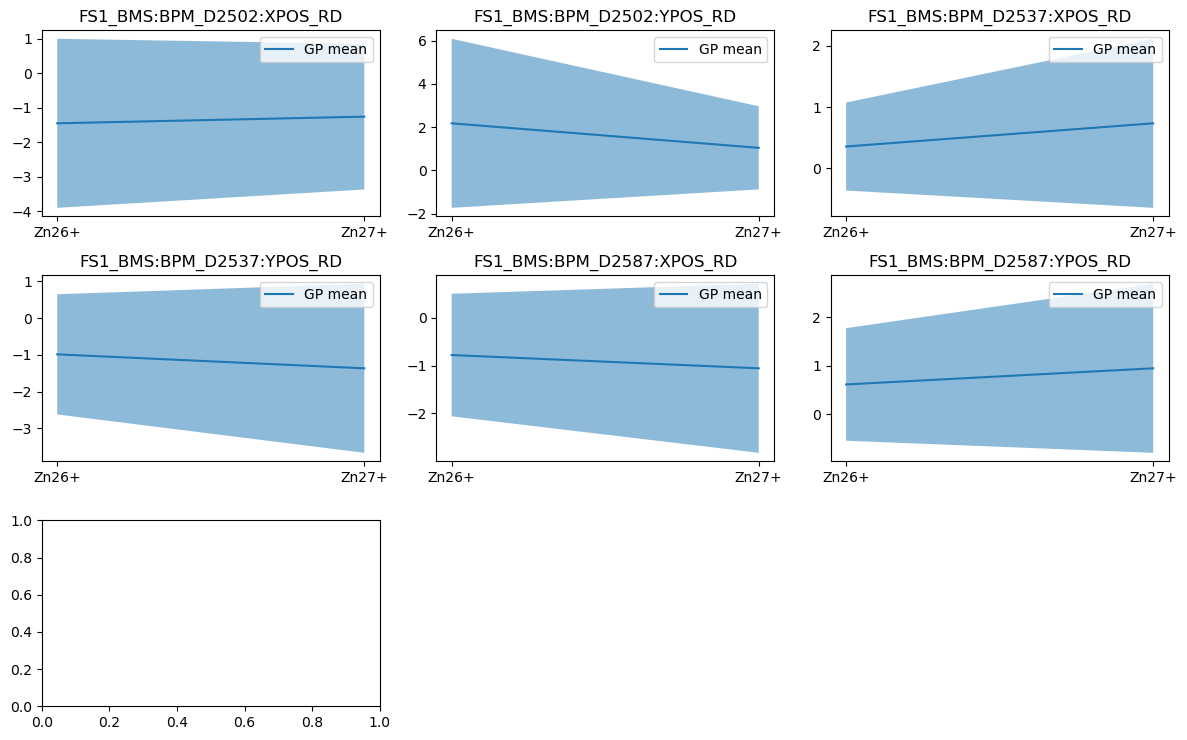

In [19]:
# fig,ax = plot_msGP_over_states(
#     msbo.msGP,
#     control_values=control_values,
#     control_data_labels = ["init"],
#     state_names = state_names,
#     objective_PVs = objective_PVs,
#     multi_state_objective_fn = multi_state_objective_fn,
#     CL = 3,
# )

# l_ytrue = np.zeros((len(control_values),n_state,n_obj))
# l_obj = np.zeros(len(control_values))

# for i,x in enumerate(control_values):
#     for istate in range(n_state):
#         future = msbo.evaluator.submit(x,istate=istate)
#         df, df_ramp  = msbo.evaluator.get_result(future)
#         y = df[objective_PVs].mean().values
#         l_ytrue[i,istate,:] = y
#     l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

# for i_obj in range(n_obj):
#     for i_c in range(len(control_values)):
#         ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
# ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

# 1st globalBO

In [23]:
msbo.optimize_global(neval=n_eval, beta=beta)
candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=0.0)
control_values = np.vstack((control_values,candidate))

MultiStateEvaluator:set_n_read: x,istate [128.67274056] 0
set: x [128.67274056 -16.        ]
set: self.control_CSETs ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV']
set: self.control_couplings {'FS1_BBS:PSQ_D2416:I_CSET': {'CSETs': ['FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'], 'RDs': ['FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'], 'coeffs': array([0.4480581, 0.4480581, 1.       ]), 'tols': [0.5, 0.5, 0.5]}}
set: self.expanded_control_CSETs ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET']
_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 128.6727405636592


,FS1_BBS:PSQ_D2416:I_CSET,FS1_BBS:CSEL_D2405:CTR_MTR.RBV,FS1_BBS:PSQ_D2424:I_CSET,FS1_BBS:PSQ_D2463:I_CSET,FS1_BBS:PSQ_D2472:I_CSET
0,128.672741,-16.0,57.652864,57.652864,128.672741


ensure_set(['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'],['FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'],[128.6727405636592, -16.0, 57.652863549047176, 57.652863549047176, 128.6727405636592],tol=[0.5, 0.1, 0.5, 0.5, 0.5],timeout=20)
Set the above PVs and press any key to continue...
set: ensure_set done
MultiStateEvaluator:set: ramping_df None
MultiStateEvaluator:set_n_read: ret, ramping_df set_manually None
read: fetching
read: self.fetch_data_monitors ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET', 'FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD', 'FS1_BMS:BPM_D2502:XPOS_RD', 'FS1_BMS:BPM_D2502:YPOS_RD', 'FS1_BM

MultiStateEvaluator:set_n_read: x,istate [135.46902476] 0
set: x [135.46902476 -16.        ]
set: self.control_CSETs ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV']
set: self.control_couplings {'FS1_BBS:PSQ_D2416:I_CSET': {'CSETs': ['FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'], 'RDs': ['FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'], 'coeffs': array([0.4480581, 0.4480581, 1.       ]), 'tols': [0.5, 0.5, 0.5]}}
set: self.expanded_control_CSETs ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET']
_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 135.4690247558338


,FS1_BBS:PSQ_D2416:I_CSET,FS1_BBS:CSEL_D2405:CTR_MTR.RBV,FS1_BBS:PSQ_D2424:I_CSET,FS1_BBS:PSQ_D2463:I_CSET,FS1_BBS:PSQ_D2472:I_CSET
0,135.469025,-16.0,60.697994,60.697994,135.469025


ensure_set(['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'],['FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'],[135.4690247558338, -16.0, 60.69799372545884, 60.69799372545884, 135.4690247558338],tol=[0.5, 0.1, 0.5, 0.5, 0.5],timeout=20)
Set the above PVs and press any key to continue...
set: ensure_set done
MultiStateEvaluator:set: ramping_df None
MultiStateEvaluator:set_n_read: ret, ramping_df set_manually None
read: fetching
read: self.fetch_data_monitors ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET', 'FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD', 'FS1_BMS:BPM_D2502:XPOS_RD', 'FS1_BMS:BPM_D2502:YPOS_RD', 'FS1_BMS:

,FS1_BBS:PSQ_D2416:I_CSET,FS1_BBS:CSEL_D2405:CTR_MTR.RBV,FS1_BBS:PSQ_D2424:I_CSET,FS1_BBS:PSQ_D2463:I_CSET,FS1_BBS:PSQ_D2472:I_CSET
0,125.370084,16.0,56.173082,56.173082,125.370084


ensure_set(['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'],['FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'],[125.37008402321614, 16.0, 56.173081537399334, 56.173081537399334, 125.37008402321614],tol=[0.5, 0.1, 0.5, 0.5, 0.5],timeout=20)
Set the above PVs and press any key to continue...
set: ensure_set done
MultiStateEvaluator:set: ramping_df None
MultiStateEvaluator:set_n_read: ret, ramping_df set_manually None
read: fetching
read: self.fetch_data_monitors ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET', 'FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD', 'FS1_BMS:BPM_D2502:XPOS_RD', 'FS1_BMS:BPM_D2502:YPOS_RD', 'FS1_B

MultiStateEvaluator:set_n_read: x,istate [130.8888623] 1
set: x [130.8888623  16.       ]
set: self.control_CSETs ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV']
set: self.control_couplings {'FS1_BBS:PSQ_D2416:I_CSET': {'CSETs': ['FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'], 'RDs': ['FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'], 'coeffs': array([0.4480581, 0.4480581, 1.       ]), 'tols': [0.5, 0.5, 0.5]}}
set: self.expanded_control_CSETs ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET']
_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 130.88886230101897


,FS1_BBS:PSQ_D2416:I_CSET,FS1_BBS:CSEL_D2405:CTR_MTR.RBV,FS1_BBS:PSQ_D2424:I_CSET,FS1_BBS:PSQ_D2463:I_CSET,FS1_BBS:PSQ_D2472:I_CSET
0,130.888862,16.0,58.645815,58.645815,130.888862


ensure_set(['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET'],['FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD'],[130.88886230101897, 16.0, 58.64581484216796, 58.64581484216796, 130.88886230101897],tol=[0.5, 0.1, 0.5, 0.5, 0.5],timeout=20)
Set the above PVs and press any key to continue...
set: ensure_set done
MultiStateEvaluator:set: ramping_df None
MultiStateEvaluator:set_n_read: ret, ramping_df set_manually None
read: fetching
read: self.fetch_data_monitors ['FS1_BBS:PSQ_D2416:I_CSET', 'FS1_BBS:CSEL_D2405:CTR_MTR.RBV', 'FS1_BBS:PSQ_D2424:I_CSET', 'FS1_BBS:PSQ_D2463:I_CSET', 'FS1_BBS:PSQ_D2472:I_CSET', 'FS1_BBS:PSQ_D2416:I_RD', 'FS1_BBS:CSEL_D2405:CTR_MTR.VAL', 'FS1_BBS:PSQ_D2424:I_RD', 'FS1_BBS:PSQ_D2463:I_RD', 'FS1_BBS:PSQ_D2472:I_RD', 'FS1_BMS:BPM_D2502:XPOS_RD', 'FS1_BMS:BPM_D2502:YPOS_RD', 'FS1_BMS

In [ ]:
# projection_plot(msbo,candidate)

In [ ]:
fig,ax = plot_msGP_over_states(
    msbo.msGP,
    control_values=control_values,
    control_data_labels = ["epoch0","epoch1"],
    state_names = state_names,
    objective_PVs = objective_PVs,
    multi_state_objective_fn = multi_state_objective_fn,
    CL = 3,
)

l_ytrue = np.zeros((len(control_values),n_state,n_obj))
l_obj = np.zeros(len(control_values))

for i,x in enumerate(control_values):
    for istate in range(n_state):
        future = msbo.evaluator.submit(x,istate=istate)
        df, df_ramp  = msbo.evaluator.get_result(future)
        y = df[objective_PVs].mean().values
        l_ytrue[i,istate,:] = y
    l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

for i_obj in range(n_obj):
    for i_c in range(len(control_values)):
        ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

# 2nd globalBO

In [ ]:
msbo.optimize_global(neval=n_eval, beta=beta)
candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=0.0)
control_values = np.vstack((control_values,candidate))

In [ ]:
fig,ax = plot_msGP_over_states(
    msbo.msGP,
    control_values=control_values,
    control_data_labels = ["epoch0","epoch1","epoch2"],
    state_names = state_names,
    objective_PVs = objective_PVs,
    multi_state_objective_fn = multi_state_objective_fn,
    CL = 3,
)

l_ytrue = np.zeros((len(control_values),n_state,n_obj))
l_obj = np.zeros(len(control_values))

for i,x in enumerate(control_values):
    for istate in range(n_state):
        future = msbo.evaluator.submit(x,istate=istate)
        df, df_ramp  = msbo.evaluator.get_result(future)
        y = df[objective_PVs].mean().values
        l_ytrue[i,istate,:] = y
    l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

for i_obj in range(n_obj):
    for i_c in range(len(control_values)):
        ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

In [ ]:
msbo.msGP.l_train_X[0][:n_init]

In [ ]:
msbo.msGP.l_train_X[0][n_init:n_init+n_eval]

In [ ]:
msbo.msGP.l_train_X[0][n_init+n_eval:]

In [ ]:
projection_plot_model(msbo,control_values,data_only=False)

In [ ]:
projection_plot(msbo,control_values,data_only=False)